# Examine Secondary at Predicted Branchpoints

Secondary structures are computed using ViennaRNA.

We simplify our analysis by analyzing marginalized base pair probabilities.

This analysis was inspired by the secondary structure analysis done in "RNA Bind-n-Seq: quantitative assessment of the sequence and structural binding specificity of RNA binding proteins".

We find that branchpoints overall tend to be more unstructured than
thier surroundings. However, branchpoints close to the 3'ss tend to have more structure flanking them than others. More distal branchpoints have a lack of structure, but interestingly have a bump in structure at about -10, where we observe increased GC frequency.

In [2]:
import numpy as np
import RNA
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [3]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [4]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        gene = gene.split(':')[-1]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [ ]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

In [6]:
L1, L2 = 100, 70

def bpp(seq):
    r = RNA.fold_compound(seq)
    r.pf()
    return np.array(r.bpp())[1:, 1:]

def marginal_bpp(seq):
    M = bpp(seq)
    return (np.sum(M, axis = 1) + np.sum(M, axis = 0)).reshape(-1, 1)

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L1, three
        else:
            begin, stop = three, three + L1

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X += [np.hstack([onehot(seq), marginal_bpp(seq)]).reshape(1, L1, 5)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L1 + bp - three
            else:
                bp = L1 - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 100, 5) (37110, 100, 5)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [8]:
y_novel = model.predict(X_novel[:, L1-L2:, :4]).reshape(-1, L2)
p_known = model.predict(X_known[:, L1-L2:, :4]).reshape(-1, L2)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [9]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

In [10]:
y_all   = np.hstack([np.zeros((y_all.shape[0],   L1-L2)), y_all])
y_known = np.hstack([np.zeros((y_known.shape[0], L1-L2)), y_known])

In [19]:
print y_all.shape, y_known.shape

(206292, 100) (37110, 130)


# Secondary Structure

In [11]:
def cons_novel(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, idx]
        total += 1
    return counts / total

def cons_known(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

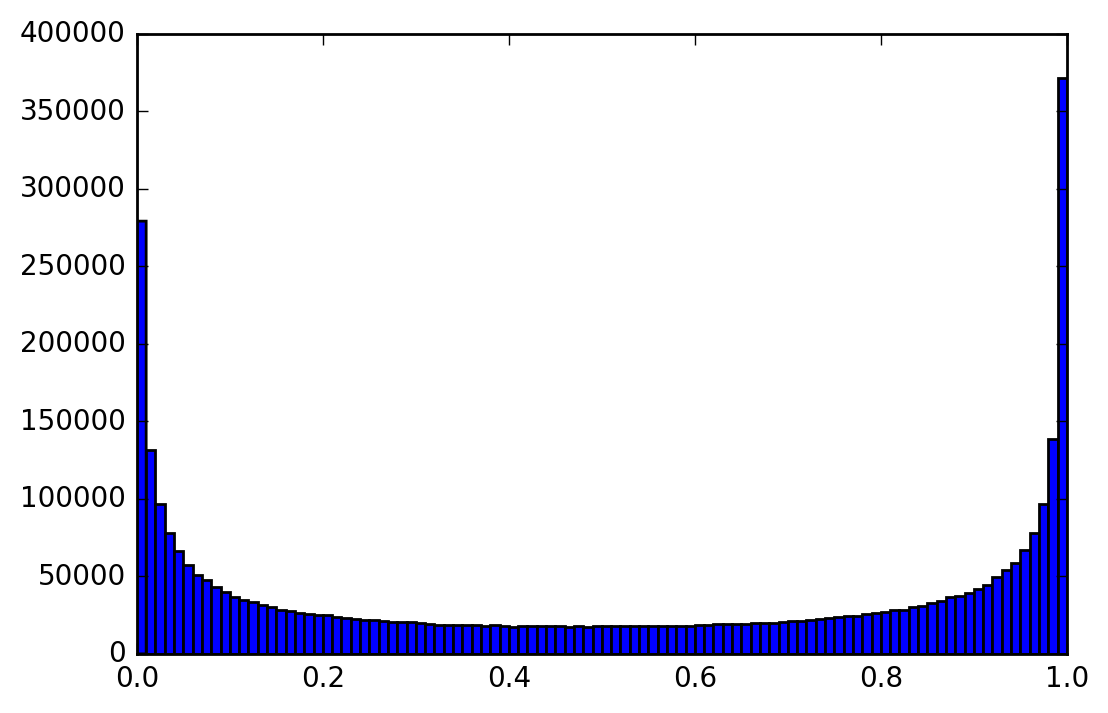

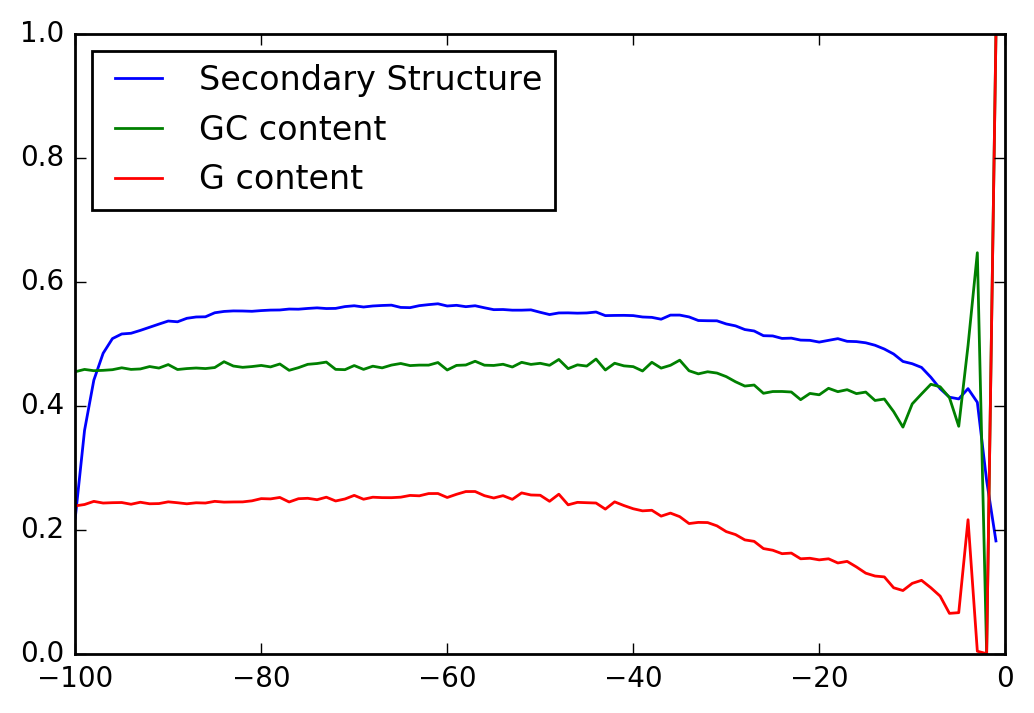

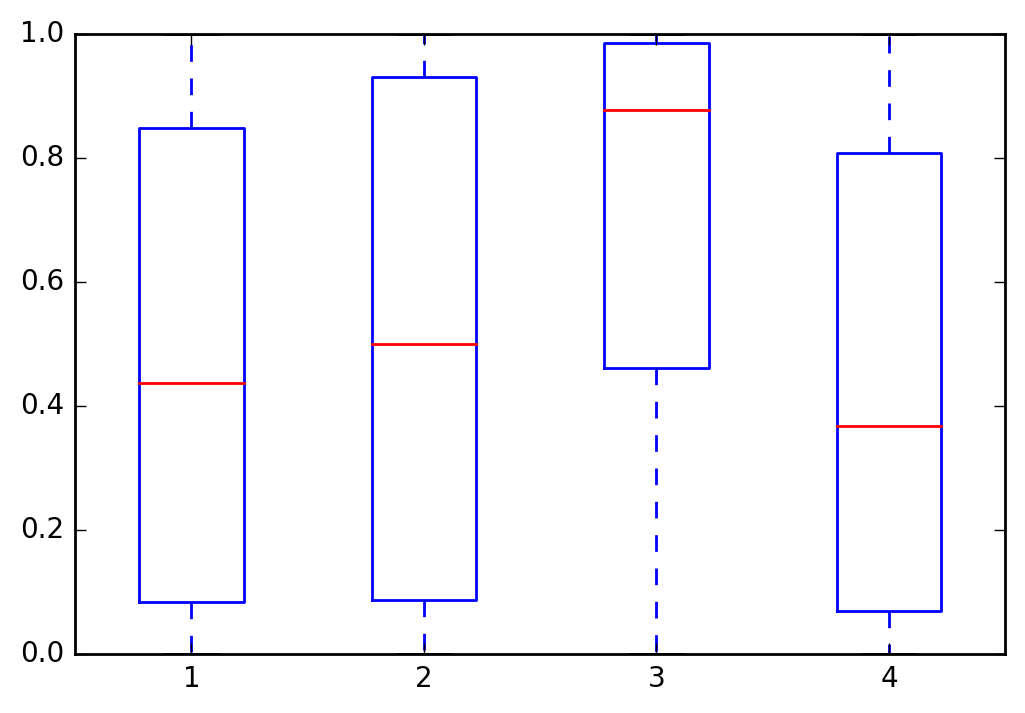

817
817


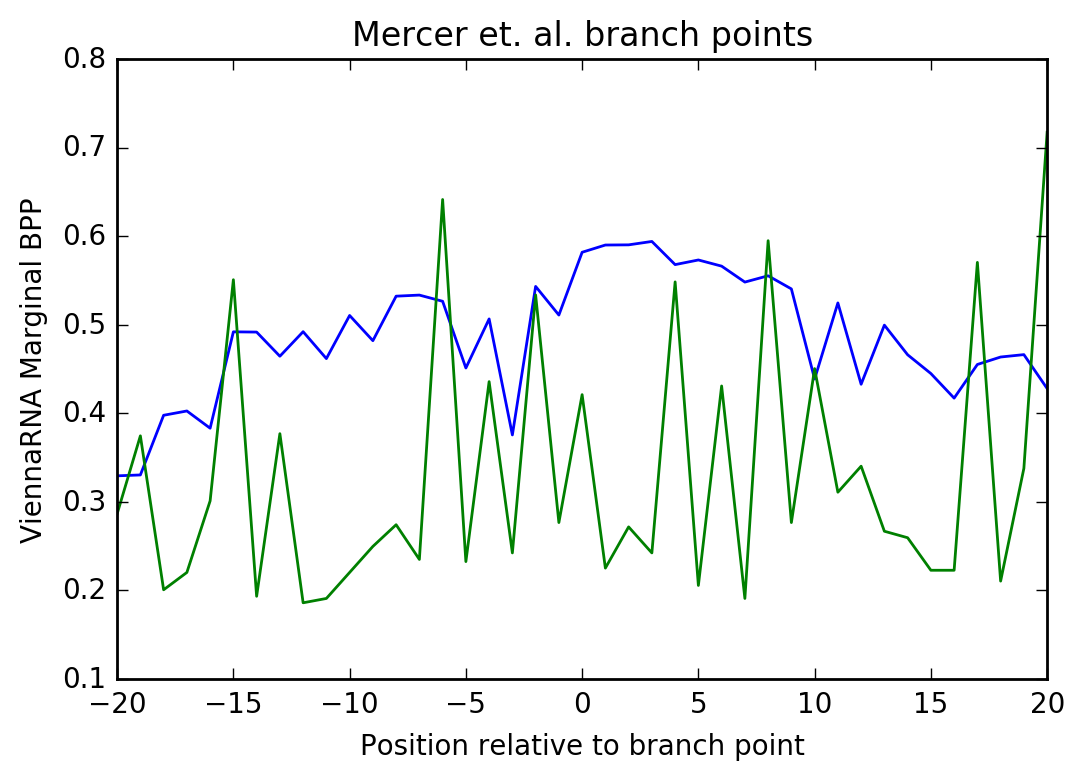

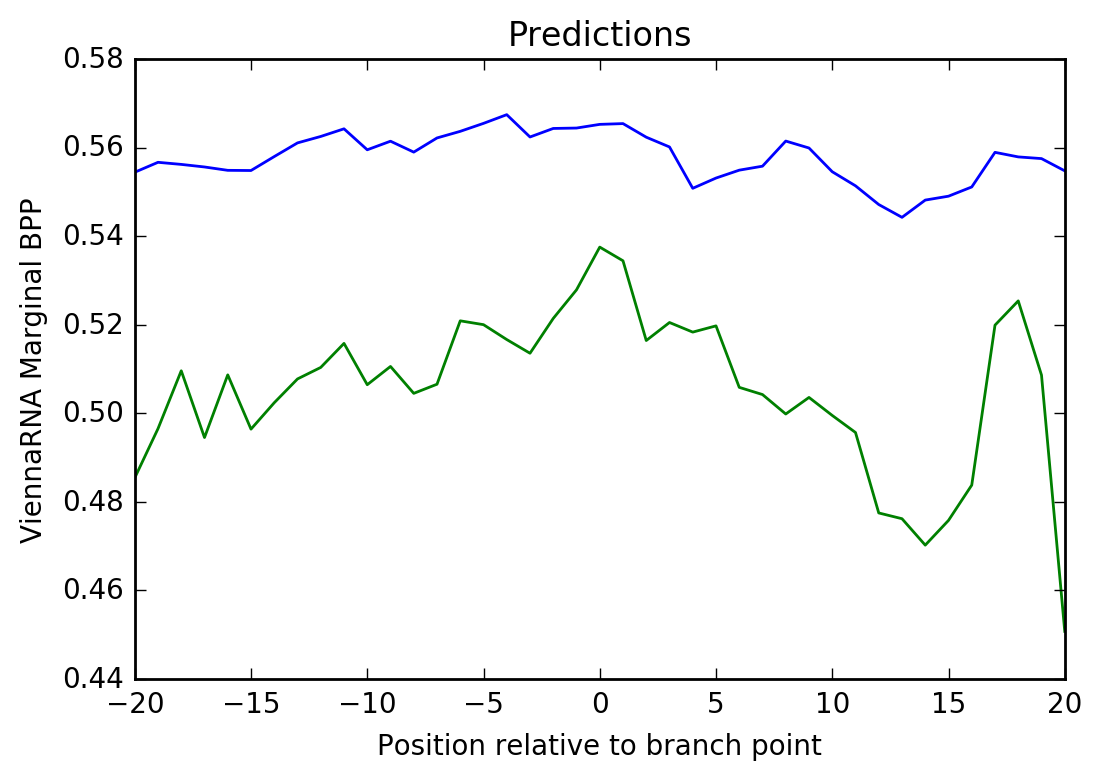

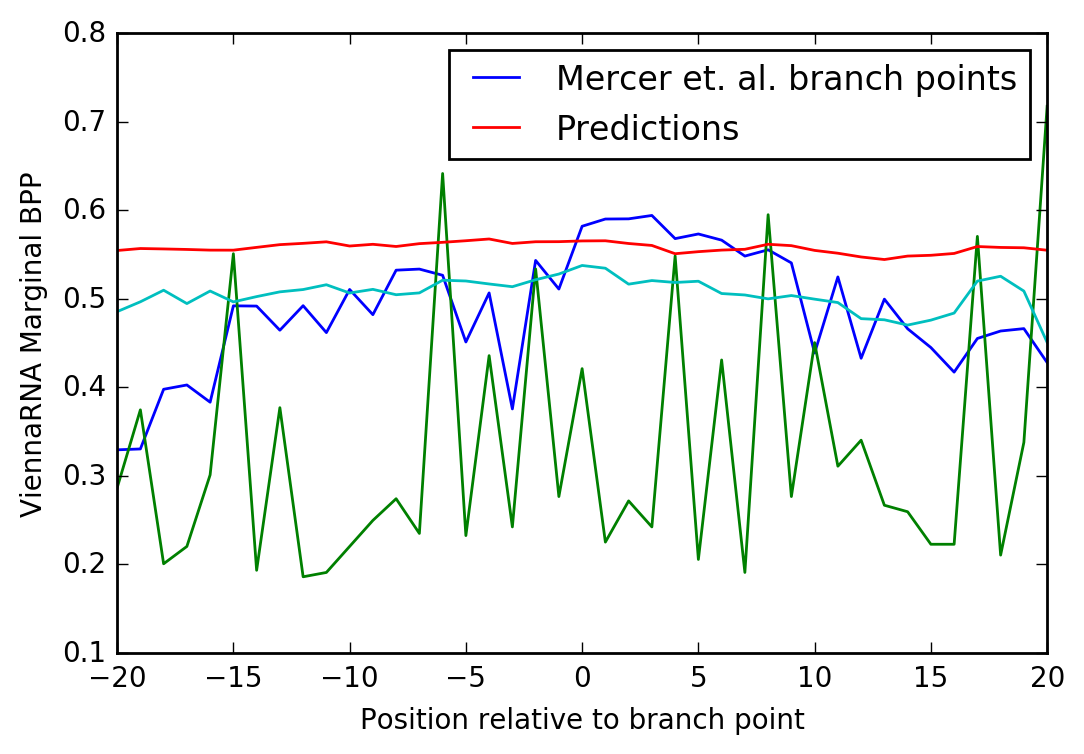

In [13]:
K = 20

plt.hist(X_known[:, :, 4].flatten(), bins = 100)
plt.show()

plt.plot(range(-L1, 0), X_known[:, :, 4].mean(axis = 0), label = 'Secondary Structure')
plt.plot(range(-L1, 0), X_known[:, :, 1].mean(axis = 0) + X_known[:, :, 2].mean(axis = 0), label = 'GC content')
plt.plot(range(-L1, 0), X_known[:, :, 2].mean(axis = 0), label = 'G content')
plt.legend(loc = 2)
plt.show()

plt.boxplot([X_known[:, :, 4][X_known[:, :, i] == 1] for i in range(4)])
plt.show()

known = cons_known(X_known, y_known, 4)
predicted = cons_novel(X_known, p_known, 4)

g_known = cons_known(X_known, y_known, 2)
g_predicted = cons_novel(X_known, p_known, 2)

names = ['Mercer et. al. branch points',
         'Predictions']
cons = [known, predicted]
gs = [g_known, g_predicted]

for name, con, g in zip(names, cons, gs):
    plt.plot(range(-K, K+1), con)
    plt.plot(range(-K, K+1), 2*g)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('ViennaRNA Marginal BPP')
    plt.show()
    
for name, con, g in zip(names, cons, gs):
    plt.plot(range(-K, K+1), con, label = name)
    plt.plot(range(-K, K+1), 2*g)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('ViennaRNA Marginal BPP')
plt.legend(loc = 'best')
plt.show()

20 80
20 80
30 1
33 3
35 2
36 3
37 7
38 10
39 45
40 67
41 93
42 102
43 141
44 123
45 117
46 141
47 150
48 183
49 216
50 227
51 226
52 292
53 324
54 377
55 467
56 528
57 633
58 769
59 854
60 1044
61 1255
62 1535
63 1766
64 2360
65 2924
66 3643
67 4431
68 5482
69 6720
70 8089
71 9178
72 9055
73 8661
74 8159
75 8116
76 7887
77 8438
78 8877
79 9059


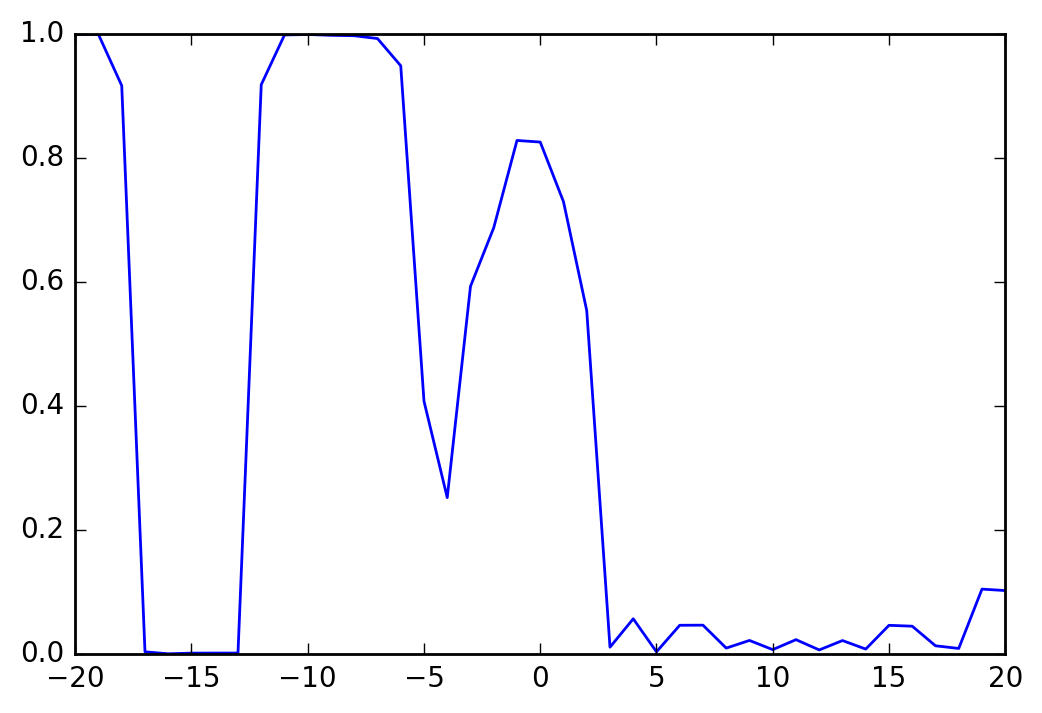

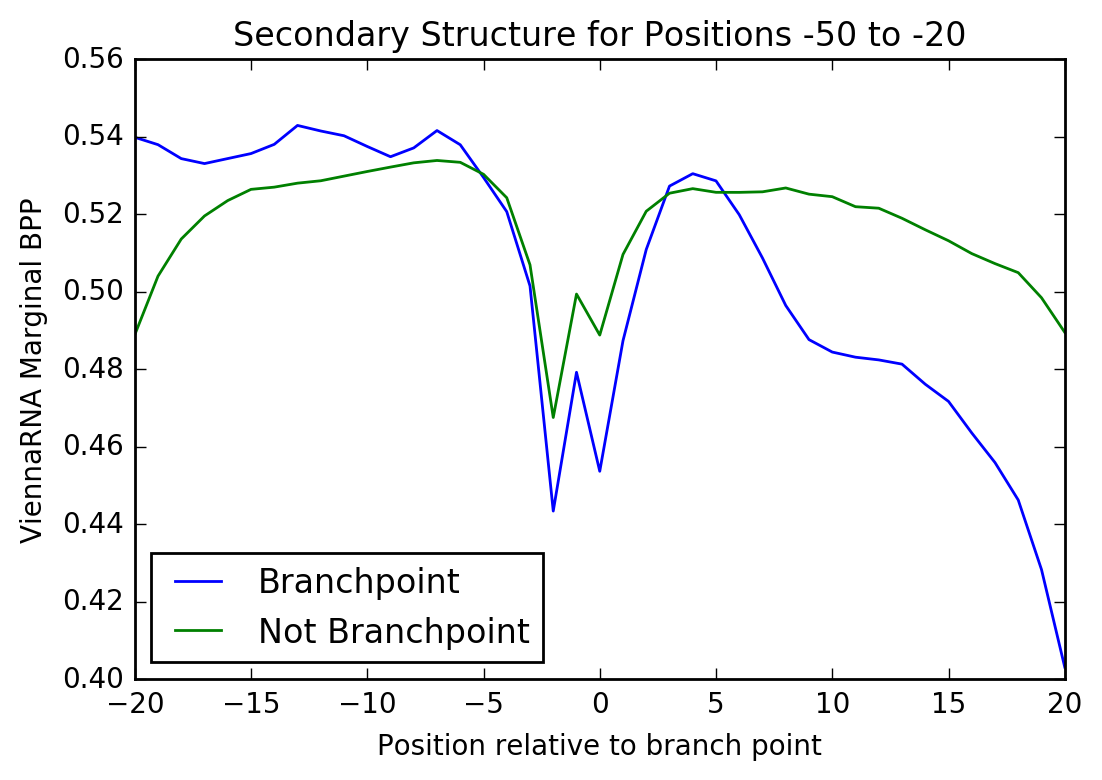

20 35
65 80
65 2924
66 3643
67 4431
68 5482
69 6720
70 8089
71 9178
72 9055
73 8661
74 8159
75 8116
76 7887
77 8438
78 8877
79 9059


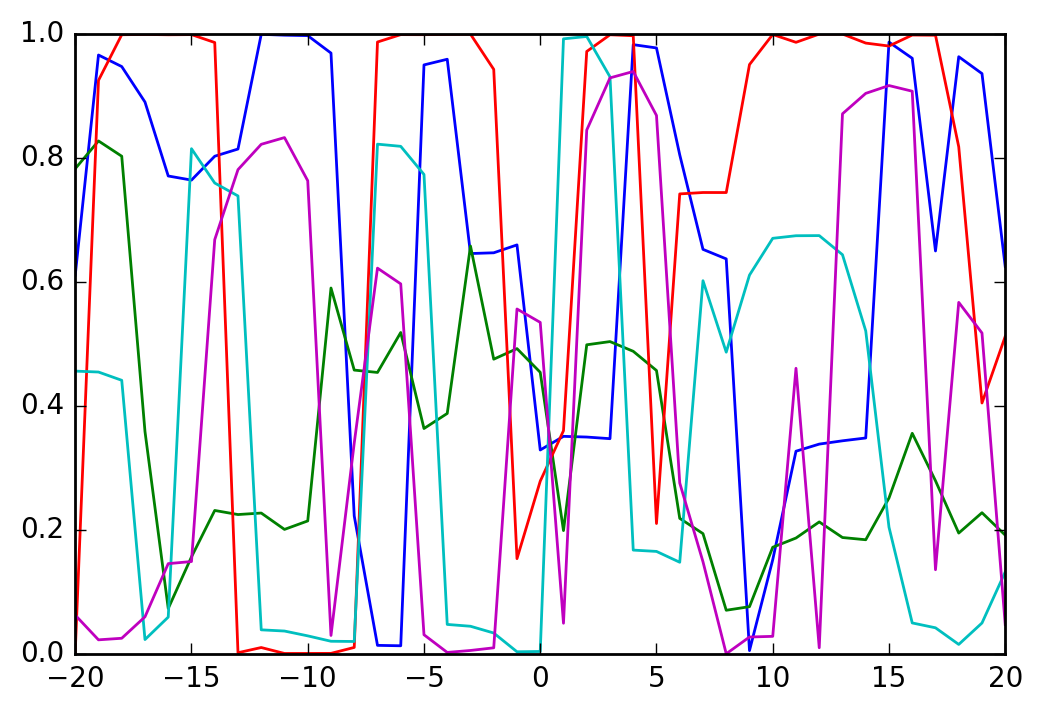

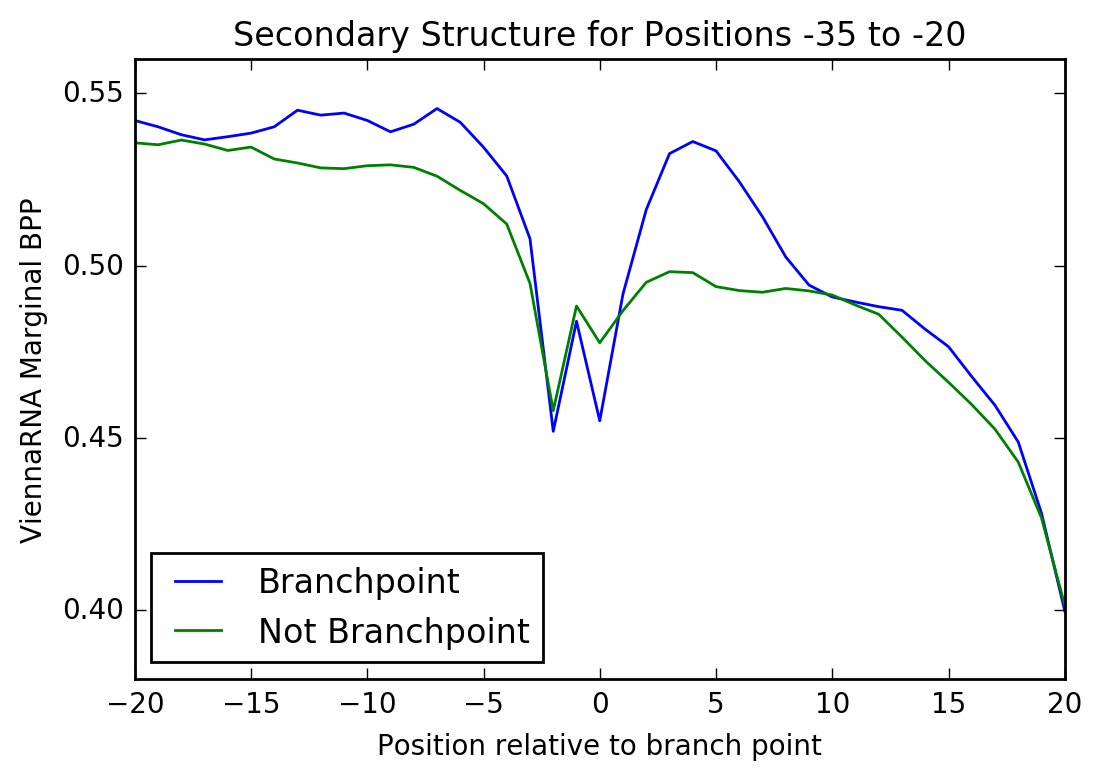

20 25
75 80
75 8116
76 7887
77 8438
78 8877
79 9059


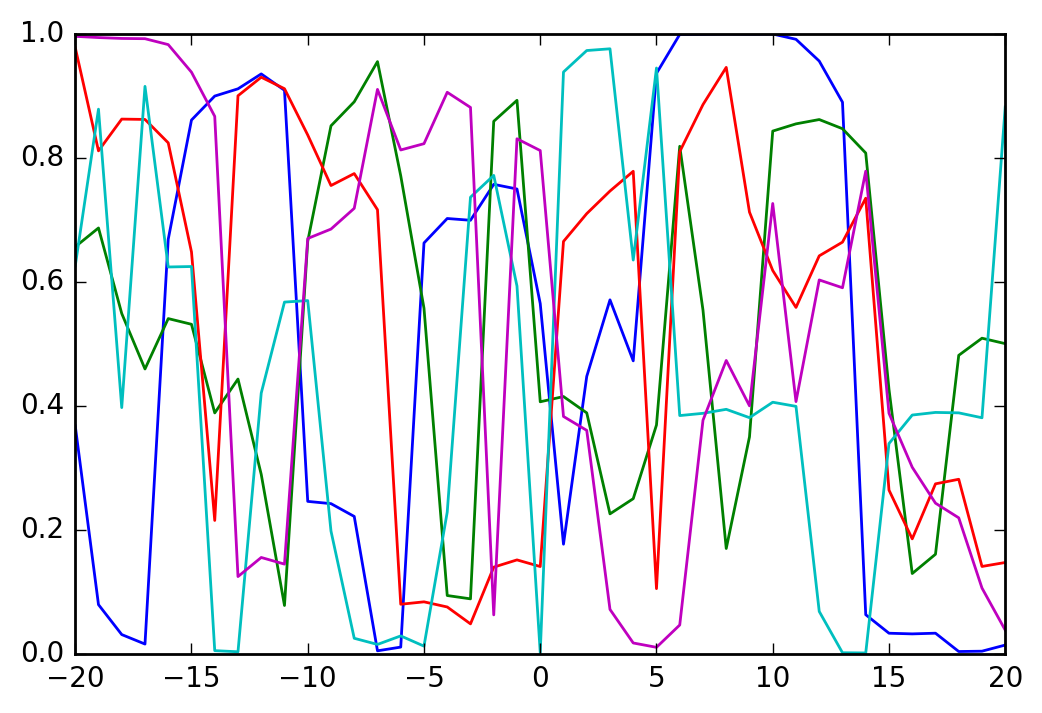

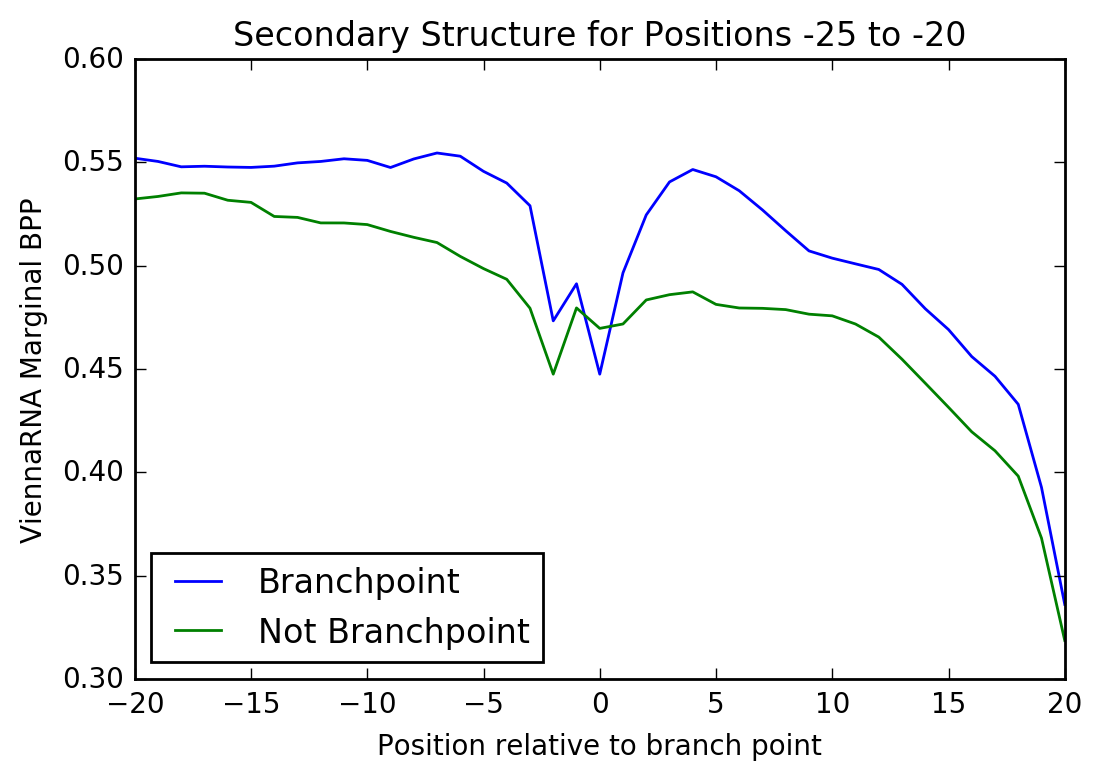

30 35
65 70
65 2924
66 3643
67 4431
68 5482
69 6720


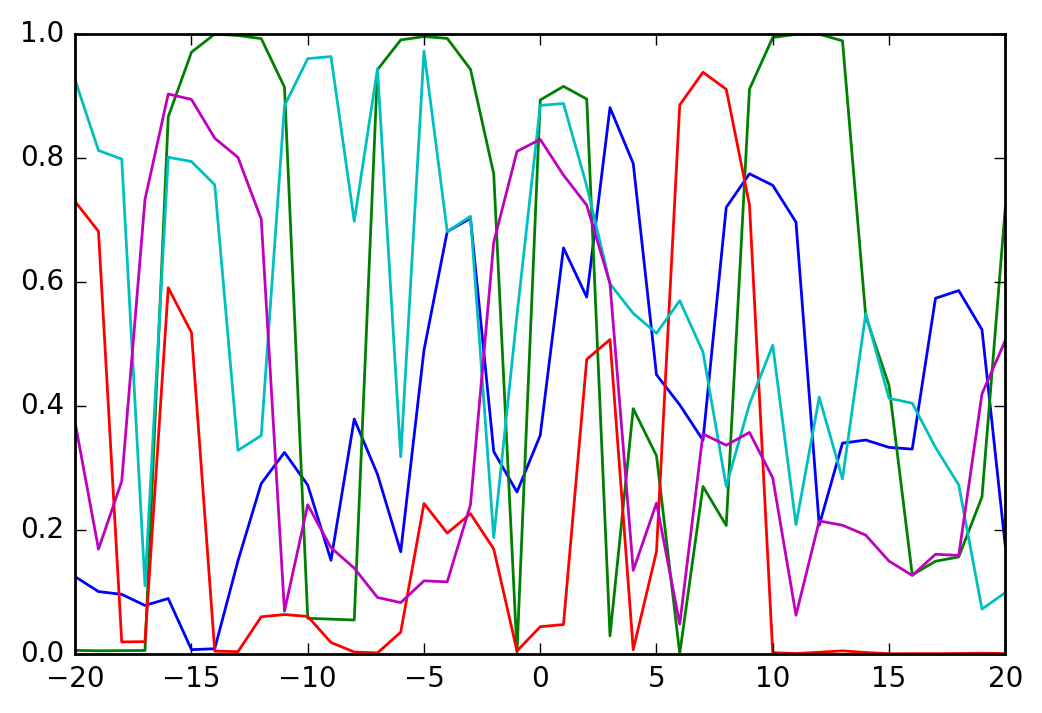

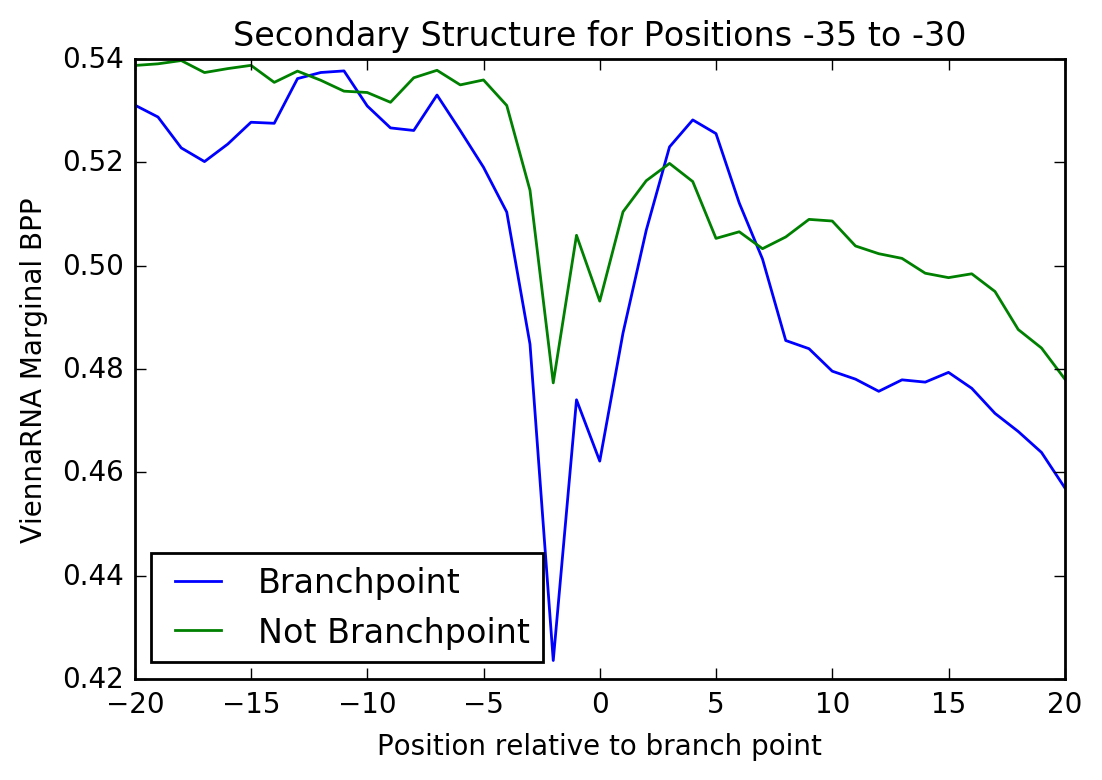

In [24]:
# Compare secondary structure at BP TNA to non-BP TNA in 22-28
from sklearn.utils import shuffle
def secondary_struct(start, end):
    print start, end
    print L1-end, L1-start
    branch, not_branch = {}, {}
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        for i in range(L1-end, L1-start):
            if not seq[i, 0]*seq[i-2, 3]: continue
            if i == bp:
                if i not in branch: branch[i] = []
                branch[i] += [seq[i-K: i+K+1, 4]]

            else:
                if i not in not_branch: not_branch[i] = []
                not_branch[i] += [seq[i-K: i+K+1, 4]]

    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = shuffle(branch[dist])[:num]
        not_branch[dist] = shuffle(not_branch[dist])[:num]
        print dist, num
    
    plt.plot(range(-K, K+1), np.vstack(branch.values()[0])[:5].T)
    plt.show()
    return (np.vstack(branch.values()).mean(axis = 0),
            np.vstack(not_branch.values()).mean(axis = 0))

b, nb = secondary_struct(K, L1-K)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -50 to -20")
plt.show()

b, nb = secondary_struct(20, 35)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -35 to -20")
plt.show()

b, nb = secondary_struct(20, 25)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -25 to -20")
plt.show()


b, nb = secondary_struct(30, 35)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -35 to -30")
plt.show()

In [5]:
# Add search for stem-loops
print K

NameError: name 'K' is not defined

In [19]:
L1 = 100

def bpp(seq):
    r = RNA.fold_compound(seq)
    r
    return np.array(r.bpp())[1:, 1:]

def marginal_bpp(seq):
    M = bpp(seq)
    return (np.sum(M, axis = 1) + np.sum(M, axis = 0)).reshape(-1, 1)

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

for intron, bps in introns.items()[:200]:
    chrom, three, strand, gene = intron
    if strand == '+':
        begin, stop = three - L1, three
    else:
        begin, stop = three, three + L1

    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    r = RNA.fold_compound(seq)
    
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L1 + bp - three
        else:
            bp = L1 - bp + three - 1
        _y[bp] = 1
    if not sum(_y): continue
            
    print r.mfe()[0]
    print ''.join(map(str, _y.astype(int)))
    

....(((((((((((.........)))).)))))))((((((.....)))))).(((...)))........((((((((...)))..)))))........
0000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000
((((.....(((((..((.(((((...............))))).))..))))).....))))......((((((....))))))...............
0000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000
.((((...(((......(((..(.(((((.((((.....))))..))))))..)))....(((((....)))))...)))..))))..............
0000000000000000000000000000000000000000000000000000000000000000000010000001000100000000000000000000
..((((.........(((((.....)))))((((.((((.....(((((...((((.(((((...))))).))))..)))))..))))))))..))))..
0000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000
....(((((((...............))))))).........(((((..((..((..((((............))))..))..))..)))))........
0000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000